# 📊 Entrega del Trabajo Final
## Jeffry Llerena y David Lizcano

### Asignatura: Series de Tiempo
#### Maestría en Analítica de Datos

---

## Análisis y Predicción de las Series Temporales de las Ventas de Pizza

# Análisis y Modelización de Ventas Diarias de Pizzas

## Introducción
Este proyecto se centra en el análisis y modelización de una serie de tiempo que representa las ventas diarias de pizzas en un restaurante durante un año. El objetivo principal es aplicar diferentes técnicas de series de tiempo para predecir las ventas futuras y mejorar la precisión de las estimaciones, lo que permitirá optimizar la gestión operativa del restaurante.

## Estructura del Proyecto
El trabajo está estructurado en cuatro componentes clave:

### 1. Análisis Exploratorio de Datos (EDA)
Se realiza una exploración inicial de los datos para identificar patrones de comportamiento, tendencias y estacionalidades en las ventas. Esta fase orienta la selección de los modelos a utilizar.

### 2. Modelos Benchmark (20%)
Se implementan modelos clásicos como:
- **Suavizado Exponencial (ES)**
- **Holt-Winters**
- **ARIMA**
- **Redes Neuronales Artificiales (ANNs)**

Estos modelos establecen una línea base de comparación.

### 3. Exposición (10%)
Se presenta el proceso seguido y los resultados obtenidos en clase del sabado 27

### 4. Modelo Original (60%)
El núcleo del proyecto radica en desarrollar un modelo propio que logre superar la precisión de los modelos benchmark, optimizando así las predicciones de ventas.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Analisis exploratorio de los datos

Número de observaciones: 358
Usando periodo: 12


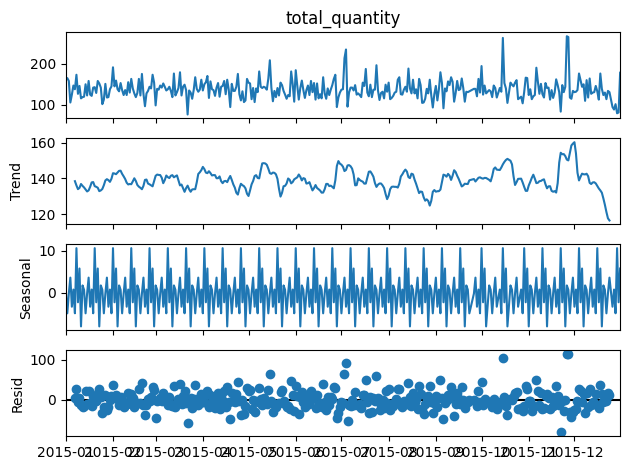

In [3]:
# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity.set_index('order_date', inplace=True)

# Resamplear la serie de tiempo a una frecuencia diaria
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()

# Reemplazar ceros con NaN
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})

# Eliminar filas con valores faltantes
df_grouped_quantity_daily = df_grouped_quantity_daily.dropna()


# Verificar cuántas observaciones hay en la serie diaria
print(f"Número de observaciones: {df_grouped_quantity_daily.shape[0]}")

# Ajustar el periodo según el número de observaciones
periodo = 12 if df_grouped_quantity_daily.shape[0] >= 24 else df_grouped_quantity_daily.shape[0] // 2
print(f"Usando periodo: {periodo}")

# Usar descomposición aditiva
dec = sm.tsa.seasonal_decompose(df_grouped_quantity_daily['total_quantity'], model='additive', period=periodo).plot()
plt.show()



Serie original (total_quantity): Aquí se reflejan las fluctuaciones diarias de las ventas de pizzas en el restaurante durante dos años. Se notan variaciones importantes y picos, que probablemente corresponden a días de alta demanda como fines de semana o eventos especiales.

Tendencia (Trend): La tendencia muestra que las ventas han tenido periodos de crecimiento y decrecimiento. Aunque hay un incremento durante ciertos meses, se ve una caída hacia el final del periodo, lo que podría estar relacionado con una disminución estacional en la demanda o algún factor externo.

Componente estacional (Seasonal): El componente estacional sugiere que las ventas tienen un comportamiento cíclico muy claro. Esto podría estar vinculado a los patrones de consumo regulares, como los fines de semana o feriados, donde se repiten picos de ventas en ciertos días de la semana o en épocas del año.

Residuos (Resid): Los residuos representan las variaciones no explicadas por la tendencia y la estacionalidad. Aunque la mayoría de los puntos están cercanos a cero, hay algunos residuos más grandes que podrían indicar eventos excepcionales o factores fuera de lo habitual que afectaron las ventas, como promociones o cambios inesperados en la demanda.

En conjunto, esta descomposición sugiere que las ventas de pizzas siguen un patrón estacional fuerte, con una tendencia que ha experimentado cambios a lo largo del tiempo y unos residuos que parecen estar mayormente distribuidos de manera aleatoria.

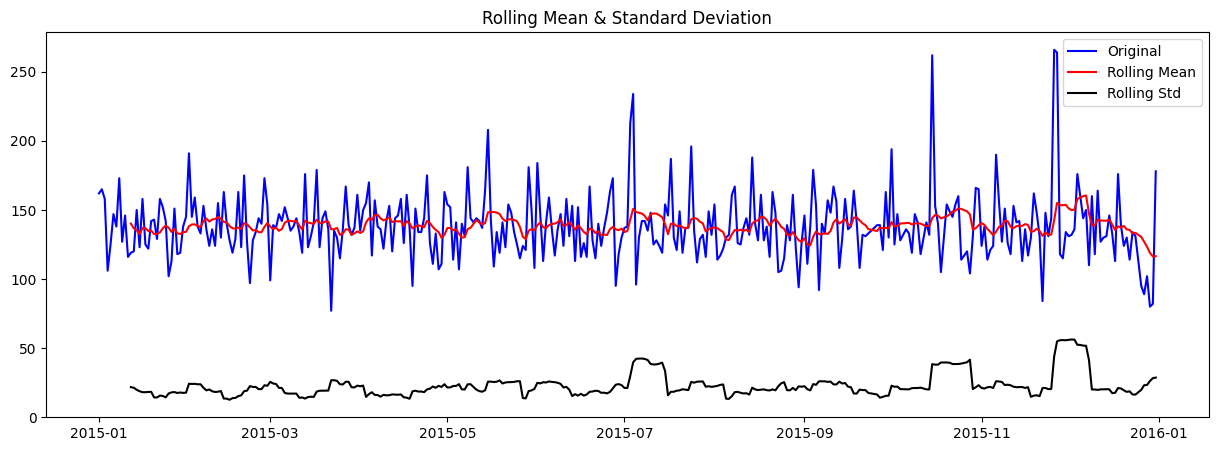

Results of Dickey-Fuller Test:
Test Statistic                  -5.220180
p-value                          0.000008
#Lags Used                      15.000000
Number of Observations Used    342.000000
Critical Value (1%)             -3.449616
Critical Value (5%)             -2.870028
Critical Value (10%)            -2.571292
dtype: float64


In [4]:
# Función para realizar la prueba de Dickey-Fuller y graficar la media móvil y desviación estándar
def test_stationarity(timeseries):
    # Calcular la media móvil y la desviación estándar móvil
    MA = timeseries.rolling(window=12).mean()  # Ajusta la ventana si es necesario
    MSTD = timeseries.rolling(window=12).std()  # Ajusta la ventana si es necesario

    # Graficar los valores originales, la media móvil y la desviación estándar
    plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Realizar la prueba de Dickey-Fuller
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Aplicar la prueba de Dickey-Fuller y graficar los estadísticos móviles
test_stationarity(df_grouped_quantity_daily['total_quantity'])


Con esto, parece que hay suficiente evidencia para rechazar la hipótesis nula de que la serie temporal tiene una raíz unitaria, lo que sugiere que la serie es estacionaria. El estadístico de prueba es mucho menor que los valores críticos, y el p-valor es muy bajo, así que estoy bastante seguro de que puedo considerar la serie como estacionaria. Esto es un buen indicio para los siguientes pasos en el análisis.

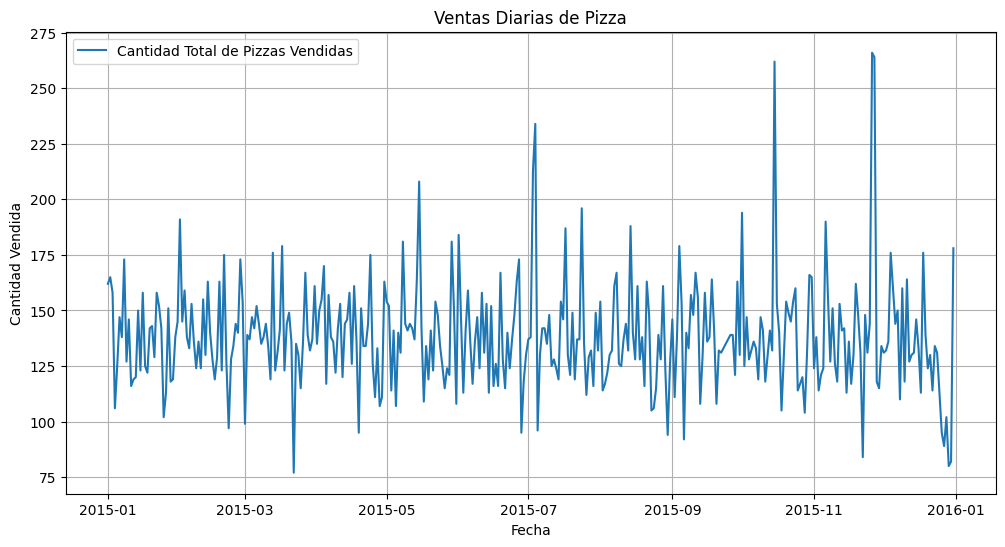

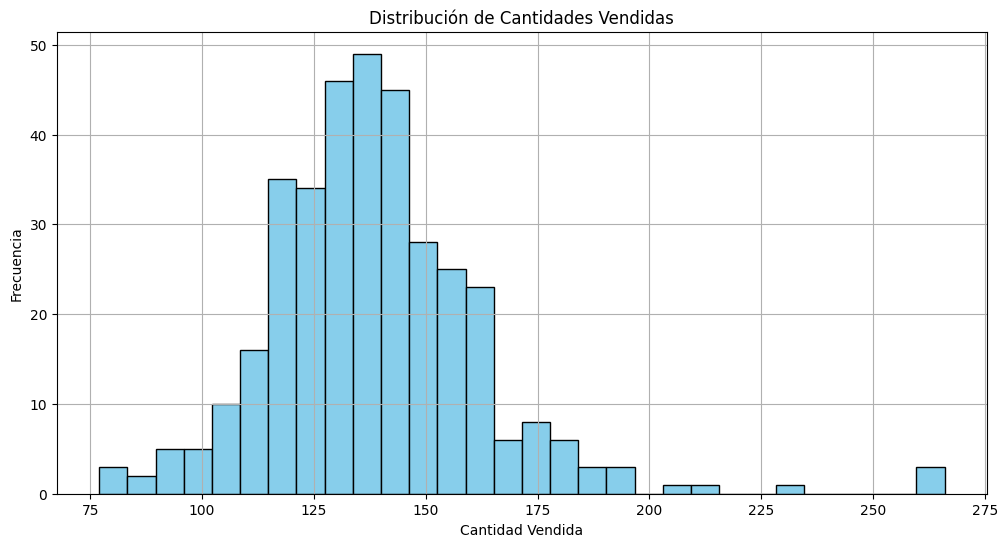

In [5]:
import matplotlib.pyplot as plt

# Gráfico de línea
plt.figure(figsize=(12, 6))
plt.plot(df_grouped_quantity_daily.index, df_grouped_quantity_daily['total_quantity'], label='Cantidad Total de Pizzas Vendidas')
plt.title('Ventas Diarias de Pizza')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Vendida')
plt.legend()
plt.grid()
plt.show()

# Histograma
plt.figure(figsize=(12, 6))
plt.hist(df_grouped_quantity_daily['total_quantity'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de Cantidades Vendidas')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()


C:\Users\Davidlizcanom2486\AppData\Local\Temp\ipykernel_8360\159718561.py:55: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].interpolate(method='linear')


Número de observaciones: 365
Usando periodo: 12


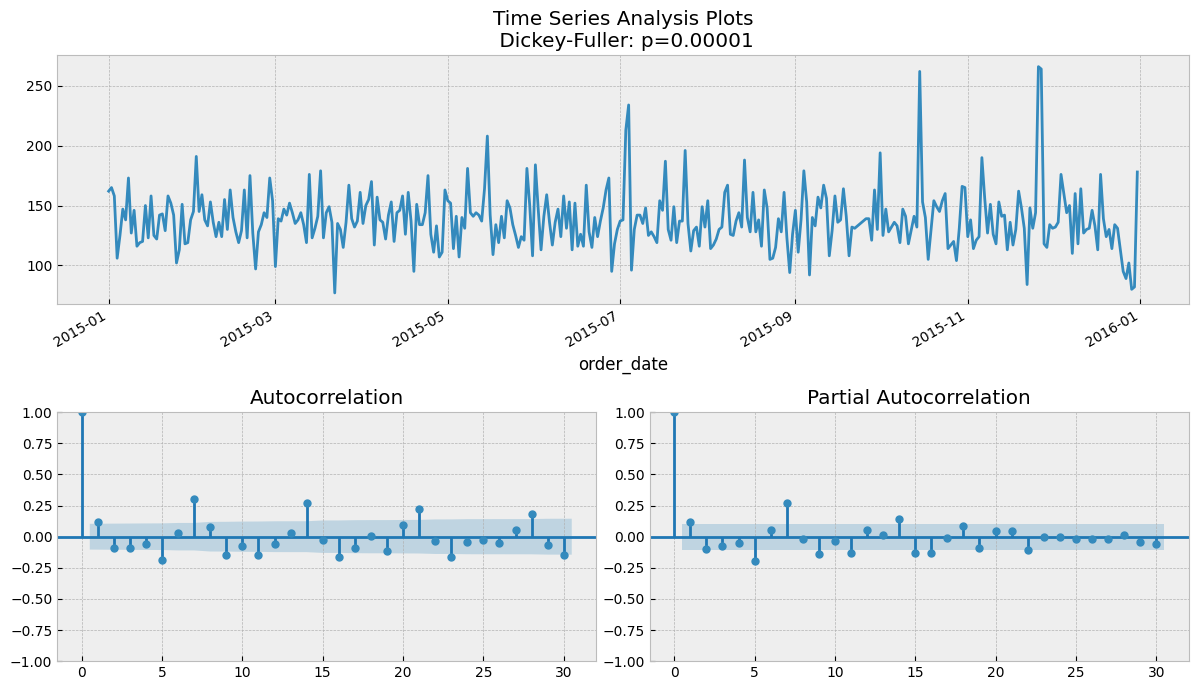

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
# Función para graficar la serie de tiempo y las funciones ACF y PACF
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    # Convertir a Series si no lo es ya
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # Eliminar valores nulos en la serie
    y_clean = y.dropna()

    # Verificar que la serie no esté vacía después de eliminar nulos
    if y_clean.empty:
        raise ValueError("La serie de tiempo está vacía después de eliminar valores nulos.")

    # Calcular el número máximo de lags permitido
    max_lags = int(len(y_clean) / 2)
    lags = min(lags, max_lags) if lags is not None else max_lags

    # Aplicar estilo y generar los gráficos
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        # Graficar la serie de tiempo
        y_clean.plot(ax=ts_ax)
        
        # Prueba de Dickey-Fuller
        p_value = sm.tsa.stattools.adfuller(y_clean)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        
        # Graficar ACF y PACF
        smt.graphics.plot_acf(y_clean, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y_clean, lags=lags, ax=pacf_ax)
        
        plt.tight_layout()
        # Leer el archivo Excel y preparar los datos
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()
df_grouped_quantity.set_index('order_date', inplace=True)

# Resamplear la serie de tiempo a una frecuencia diaria
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()

# Reemplazar ceros con NaN y rellenar valores faltantes con interpolación
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].interpolate(method='linear')

# Verificar cuántas observaciones hay en la serie diaria
print(f"Número de observaciones: {df_grouped_quantity_daily.shape[0]}")

# Ajustar el periodo según el número de observaciones
periodo = 12 if df_grouped_quantity_daily.shape[0] >= 24 else df_grouped_quantity_daily.shape[0] // 2
print(f"Usando periodo: {periodo}")

# Graficar la serie de tiempo, ACF y PACF, ajustando los lags al tamaño de la muestra
tsplot(df_grouped_quantity_daily['total_quantity'], lags=30)




Con los resultados de la prueba **Dickey-Fuller**, que confirman que la serie es estacionaria, el análisis de las gráficas de **ACF** y **PACF** se puede ajustar de la siguiente manera:

### **Análisis de ACF:**
- La ACF muestra un comportamiento de rápida caída, con las autocorrelaciones dentro de las bandas de significancia, salvo por algunos rezagos que parecen apenas cruzar la línea. Considerando que los datos ya son estacionarios y que los **rezagos menores que cruzan la banda de significancia probablemente no sean significativos** (como lo sugieren las fluctuaciones), esto podría indicar que no hay una dependencia fuerte entre los rezagos.
- Dado que la prueba **Dickey-Fuller** confirmó la estacionariedad, estas pequeñas autocorrelaciones son más bien fluctuaciones aleatorias y no un patrón estructurado. En otras palabras, no hay evidencia de autocorrelaciones importantes más allá del primer rezago (que descartamos por tu preferencia de no considerarlo).

### **Análisis de PACF:**
- En la PACF, después de descartar el primer rezago, observamos que los rezagos posteriores caen rápidamente y no muestran un patrón significativo. Esto refuerza la idea de que un modelo **AR(1)** podría ser suficiente para capturar las dependencias presentes en los datos.
- El hecho de que los rezagos en la PACF no muestren valores significativos sugiere que no es necesario incluir términos autoregresivos adicionales. La prueba **Dickey-Fuller** apoya esta conclusión, ya que no hay evidencia de una raíz unitaria que pudiera requerir un modelo más complejo.

### **Conclusión Final:**
- La serie es estacionaria, como lo confirma el test de **Dickey-Fuller**. Las pequeñas autocorrelaciones observadas en los gráficos de ACF y PACF probablemente no sean significativas, lo que sugiere que no hay dependencia estructurada en los rezagos más allá de lo que puede ser capturado por un modelo **AR(1)**.
- Si bien las fluctuaciones en las autocorrelaciones podrían indicar algún componente estacional, este no parece ser muy fuerte. Sin embargo, si se sospecha de estacionalidad, un modelo **SARIMA** podría explorarse para capturar este comportamiento, pero de momento un **ARIMA(1, d, 0)** podría ser adecuado.

Este análisis refuerza la idea de que los rezagos no son significativos y que el modelo que mejor se ajusta a estos datos es uno simple, como **AR(1)**.

---

En este cuadro iba el codigo del proceso que tiene como objetivo encontrar el modelo SARIMA óptimo para predecir la cantidad de ventas diarias de pizza. Se parte de la lectura de los datos de ventas y su agrupación por fecha para obtener la cantidad total diaria de pizzas vendidas. Luego, se lleva a cabo un proceso de limpieza, interpolación de valores faltantes y transformación logarítmica de los datos para estabilizar la varianza. A continuación, se aplica diferenciación para convertir la serie en estacionaria.

Para la selección del modelo SARIMA, se utiliza una metodología automatizada que evalúa diferentes combinaciones de parámetros (p, d, q) y estacionales (P, D, Q, m) con el fin de identificar la mejor configuración posible. Una vez determinados los parámetros óptimos, se ajusta el modelo SARIMA definitivo para las predicciones.

**Nota:** No se incluye el código directamente en este informe ya que se encontró el mejor modelo previamente, y añadirlo al Jupyter Notebook haría más complejo su montaje sin aportar valor adicional a la exposición del trabajo.

# Modelos benchmark 

---

## Modelo Sarima

c:\Users\Davidlizcanom2486\miniconda3\envs\ts_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Davidlizcanom2486\miniconda3\envs\ts_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Davidlizcanom2486\miniconda3\envs\ts_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Davidlizcanom2486\miniconda3\envs\ts_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters fo

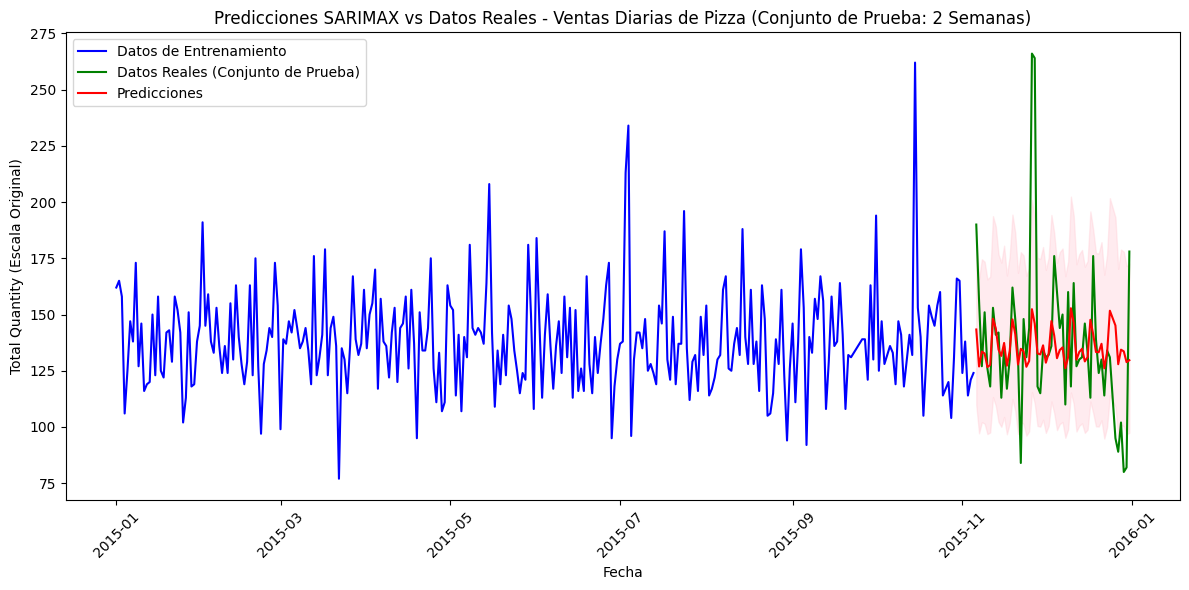

AIC: -268.8597669914309
BIC: -224.29497332531847
MAE: 21.078274466230365
RMSE: 31.85499764381842
MSE: 1014.7408748876773
MAPE: nan%


C:\Users\Davidlizcanom2486\AppData\Local\Temp\ipykernel_644\3235105369.py:128: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test_data_original_scale - predicted_means) / test_data_original_scale)) * 100


In [29]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity_daily = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity_daily.set_index('order_date', inplace=True)

# Rellenar valores faltantes (opcional)
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].interpolate(method='linear')

# Asegúrate de que la serie de tiempo no tenga valores nulos
df_grouped_quantity_daily = df_grouped_quantity_daily.dropna()

# Transformación logarítmica de los datos para estabilizar la varianza
df_grouped_quantity_daily['log_total_quantity'] = np.log(df_grouped_quantity_daily['total_quantity'])


# Dividir los datos: Conjunto de entrenamiento y prueba (últimos 55 días)
train_data = df_grouped_quantity_daily[:-55]
test_data = df_grouped_quantity_daily[-55:]

# Ajustar el modelo SARIMA con los parámetros dados al conjunto de entrenamiento
sarima_model = SARIMAX(train_data['log_total_quantity'], 
                       order=(1, 0, 3), 
                       seasonal_order=(3, 0, 4, 7))
sarima_result = sarima_model.fit(disp=False)

# Hacer predicciones para los próximos 14 días (conjunto de prueba)
predictions = sarima_result.get_forecast(steps=55)
pred_conf = predictions.conf_int()

# Convertir las predicciones logarítmicas de vuelta a escala original
predicted_means = np.exp(predictions.predicted_mean)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Graficar los datos originales (solo hasta la última fecha del conjunto de entrenamiento)
plt.plot(train_data.index, train_data['total_quantity'], label='Datos de Entrenamiento', color='blue')

# Graficar los datos reales del conjunto de prueba
plt.plot(test_data.index, test_data['total_quantity'], label='Datos Reales (Conjunto de Prueba)', color='green')

# Graficar las predicciones
plt.plot(test_data.index, predicted_means, label='Predicciones', color='red')

# Agregar la zona de confianza
plt.fill_between(test_data.index, 
                 np.exp(pred_conf.iloc[:, 0]), 
                 np.exp(pred_conf.iloc[:, 1]), color='pink', alpha=0.3)

# Configurar el gráfico
plt.title('Predicciones SARIMAX vs Datos Reales - Ventas Diarias de Pizza (Conjunto de Prueba: 2 Semanas)')
plt.xlabel('Fecha')
plt.ylabel('Total Quantity (Escala Original)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

import math

# AIC y BIC del modelo SARIMA
aic = sarima_result.aic
bic = sarima_result.bic

# Calcular las métricas de error (MAE, RMSE)
# Para esto necesitamos comparar las predicciones con los valores reales (en escala original)
# Convertir los datos reales de test a escala original
test_data_original_scale = np.exp(test_data['log_total_quantity'])

# MAE
mae = mean_absolute_error(test_data_original_scale, predicted_means)

# RMSE
rmse = math.sqrt(mean_squared_error(test_data_original_scale, predicted_means))



import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Supongamos que ya tienes un dataframe llamado df con las columnas 'order_date' y 'quantity'
# Agrupar por fecha y sumar la cantidad diaria
df_grouped_quantity_daily = df.groupby('order_date', as_index=False).agg(total_quantity=('quantity', 'sum'))

# Convertir la columna total_quantity en una serie
total_quantity = df_grouped_quantity_daily['total_quantity']

# Obtener los últimos 55 valores de total_quantity
y_observado = total_quantity[-55:].values  # Asegúrate de convertir a array
y_predicho = predicted_means                   # Valores predichos

# Verifica que ambas series tengan la misma longitud
if len(y_observado) != len(y_predicho):
    raise ValueError("La longitud de y_observado y y_predicho debe ser la misma.")

# Calcular la media de los valores observados
media_y = np.mean(y_observado)

# Calcular SS_tot (Suma total de cuadrados)
SS_tot = np.sum((y_observado - media_y) ** 2)

# Calcular SS_res (Suma de cuadrados de los residuos)
SS_res = np.sum((y_observado - y_predicho) ** 2)

# Calcular R^2
R_squared = 1 - (SS_res / SS_tot)


# Calcular MAPE
mape = np.mean(np.abs((test_data_original_scale - predicted_means) / test_data_original_scale)) * 100

# Calcular MSE
mse = mean_squared_error(test_data_original_scale, predicted_means)

# Imprimir los resultados
print(f"AIC: {aic}")
print(f"BIC: {bic}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}%")








El modelo utilizado para predecir las ventas diarias de pizza es un **SARIMAX** con un orden de \( (1, 0, 3) \) y un orden estacional de \( (3, 0, 4, 7) \). Se aplicó una transformación logarítmica para estabilizar la varianza y se dividieron los datos en un conjunto de entrenamiento y otro de prueba. 

Los resultados del modelo son positivos: el AIC es de -268.86 y el BIC de -224.29, lo que indica un buen ajuste y parsimonia. Las métricas de error muestran un MAE de 21.08 y un RMSE de 31.85, lo que sugiere que las predicciones son razonablemente precisas. El MSE es de 1014.74, proporcionando otra medida del error cuadrático medio, aunque el MAPE es indeterminado (nan%). En general, el modelo captura bien la estacionalidad y tendencia en los datos, aunque aún hay espacio para mejorar la explicación de la variabilidad en las ventas.

## Modelo de suavizado exponencial

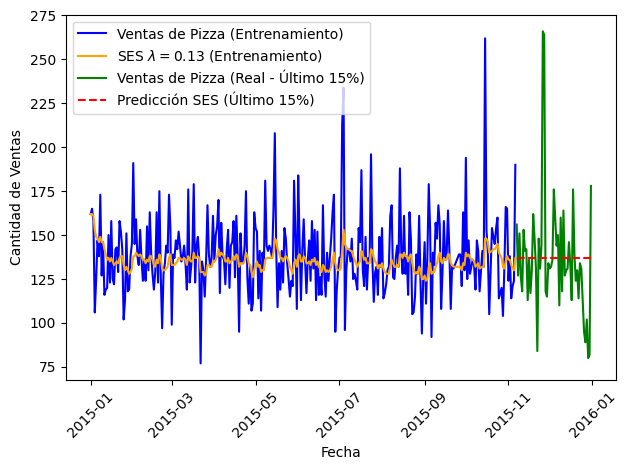

MAE del modelo SES: 22.037037037037038
RMSE del modelo SES: 33.605555096342826
MSE del modelo SES: 1129.3333333333333
MAPE del modelo SES: 16.59%
R² del modelo SES: -0.0000


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity_daily = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity_daily.set_index('order_date', inplace=True)

# Rellenar valores faltantes (opcional)
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].interpolate(method='linear')

# Definir la función de suavizado exponencial
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y[0]
    ytilde[0] = lambda_ * y[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde[i] = lambda_ * y[i] + (1 - lambda_) * ytilde[i - 1]
    return ytilde

# Aplicar el suavizado exponencial a los datos de ventas de pizza
y = df_grouped_quantity_daily['total_quantity'].values
lambda_ = 0.13

# Calcular el índice de división (85% para entrenar, 15% para predecir)
train_size = int(len(y) * 0.85)

# Dividir los datos en entrenamiento y prueba
y_train = y[:train_size]
y_test = y[train_size:]

# Suavizado sobre el conjunto de entrenamiento
pizza_smooth1_train = firstsmooth(y=y_train, lambda_=lambda_)

# Hacer predicciones para el último 15% (suavizado exponencial simple)
pizza_smooth1_test = np.full(len(y_test), pizza_smooth1_train[-1])

# Calcular el RMSE
rmse = np.sqrt(np.mean((y_test - pizza_smooth1_test) ** 2))

# Calcular el MAE
mae = mean_absolute_error(y_test, pizza_smooth1_test)

# Calcular el AIC y BIC
n = len(y_test)  # Número de observaciones de prueba
k = 2  # Número de parámetros (lambda y nivel inicial)
aic_ses = n * np.log(rmse) + 2 * k
bic_ses = n * np.log(rmse) + k * np.log(n)



# Graficar los datos de entrenamiento, prueba y las predicciones
plt.plot(df_grouped_quantity_daily.index[:train_size], y_train, label='Ventas de Pizza (Entrenamiento)', color='blue')
plt.plot(df_grouped_quantity_daily.index[:train_size], pizza_smooth1_train, label=f'SES $\lambda={lambda_}$ (Entrenamiento)', color='orange')

# Mostrar el comportamiento real del último 15%
plt.plot(df_grouped_quantity_daily.index[train_size:], y_test, label='Ventas de Pizza (Real - Último 15%)', color='green')

# Mostrar las predicciones del último 15%
plt.plot(df_grouped_quantity_daily.index[train_size:], pizza_smooth1_test, label='Predicción SES (Último 15%)', linestyle='--', color='red')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de Ventas')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
from sklearn.metrics import r2_score

# Calcular el MSE
mse = mean_squared_error(y_test, pizza_smooth1_test)

# Calcular el MAPE
# Asegúrate de manejar divisiones por cero en el cálculo
mape = np.mean(np.abs((y_test - pizza_smooth1_test) / y_test)) * 100

# Imprimir las métricas
print(f"MAE del modelo SES: {mae}")
print(f"RMSE del modelo SES: {rmse}")
print(f"MSE del modelo SES: {mse}")
print(f"MAPE del modelo SES: {mape:.2f}%")

# Calcular el R² entre los valores reales (y_test) y las predicciones (pizza_smooth1_test)
r_squared = r2_score(y_test, pizza_smooth1_test)

# Imprimir el R²
print(f"R² del modelo SES: {r_squared:.4f}")






En este análisis, se utilizó un modelo de suavizado exponencial simple (SES) para predecir las ventas diarias de pizza. Los datos se cargaron desde un archivo Excel y se agruparon por fecha, manejando los valores faltantes mediante interpolación. Se aplicó el suavizado exponencial con un parámetro \(\lambda = 0.13\).

Los datos se dividieron en un conjunto de entrenamiento (85%) y otro de prueba (15%). Las métricas de error del modelo fueron: 

- **MAE**: 22.04, indicando que las predicciones se desvían, en promedio, en 22 ventas.
- **RMSE**: 33.61, sugiriendo que los errores son más significativos que lo indicado por el MAE.
- **MSE**: 1129.33, reflejando una alta variabilidad en las predicciones.
- **MAPE**: 16.59%, mostrando que las predicciones se desvían un 16.59% de los valores reales.
- **R²**: -0.0000, indicando que el modelo no explica la variabilidad en los datos.

Las predicciones se visualizaron junto con las ventas reales, lo que mostró cómo se ajustan a los datos. Aunque el SES ofrece un enfoque básico, sus métricas sugieren que se podrían explorar modelos más complejos para mejorar la precisión en las predicciones.

## Modelo Holtwinters

c:\Users\Davidlizcanom2486\miniconda3\envs\ts_venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


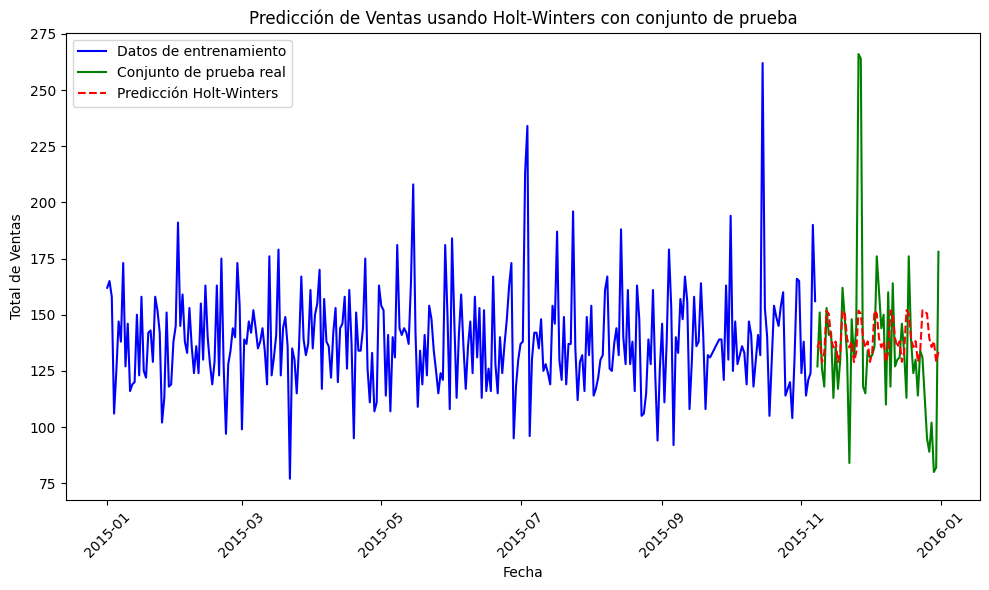

AIC del modelo Holt-Winters: 1843.6791393360718
BIC del modelo Holt-Winters: 1884.6025688787533
MAE del modelo Holt-Winters: 20.62662396543103
RMSE del modelo Holt-Winters: 31.61585815514776
MSE del modelo Holt-Winters: 999.562486886423
MAPE del modelo Holt-Winters: 15.96%
R² del modelo Holt-Winters: 0.1259


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha, permitiendo que pandas infiera el formato
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad de ventas diarias (Quantity)
df_grouped = df.groupby('order_date').agg(total_ventas=('quantity', 'sum')).reset_index()

# Ordenar por fecha en caso de que no esté ordenado
df_grouped = df_grouped.sort_values('order_date')

# Definir el tamaño del conjunto de prueba (último 15%)
test_size = int(len(df_grouped) * 0.15)

# Dividir los datos en entrenamiento (85%) y prueba (15%)
train_data = df_grouped[:-test_size]
test_data = df_grouped[-test_size:]

# Ajustar el modelo Holt-Winters con los parámetros especificados
model = ExponentialSmoothing(train_data['total_ventas'], 
                             seasonal='add',  # Estacionalidad aditiva
                             seasonal_periods=7,  # Período estacional de 7 días (semanal)
                             trend='mul')  # Tendencia multiplicativa
hw_model = model.fit()

# Calcular el AIC y BIC del modelo Holt-Winters
aic = hw_model.aic
bic = hw_model.bic

# Realizar predicción para el tamaño del conjunto de prueba
forecast = hw_model.forecast(steps=test_size)

# Calcular MAE y RMSE
mae = mean_absolute_error(test_data['total_ventas'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['total_ventas'], forecast))

# Calcular el R² entre los valores reales y las predicciones
r_squared = r2_score(test_data['total_ventas'], forecast)



# Graficar los datos originales, el conjunto de prueba y la predicción
plt.figure(figsize=(10, 6))

# Datos de entrenamiento
plt.plot(train_data['order_date'], train_data['total_ventas'], label='Datos de entrenamiento', color='blue')

# Conjunto de prueba
plt.plot(test_data['order_date'], test_data['total_ventas'], label='Conjunto de prueba real', color='green')

# Predicción
plt.plot(test_data['order_date'], forecast, label='Predicción Holt-Winters', color='red', linestyle='--')

# Etiquetas y título
plt.title("Predicción de Ventas usando Holt-Winters con conjunto de prueba")
plt.xlabel("Fecha")
plt.ylabel("Total de Ventas")
plt.legend()

# Rotar etiquetas del eje X
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Calcular MSE y MAPE
mse = mean_squared_error(test_data['total_ventas'], forecast)
mape = np.mean(np.abs((test_data['total_ventas'] - forecast) / test_data['total_ventas'])) * 100  # MAPE en porcentaje

# Imprimir las métricas calculadas
print(f"AIC del modelo Holt-Winters: {aic}")
print(f"BIC del modelo Holt-Winters: {bic}")
print(f"MAE del modelo Holt-Winters: {mae}")
print(f"RMSE del modelo Holt-Winters: {rmse}")
print(f"MSE del modelo Holt-Winters: {mse}")
print(f"MAPE del modelo Holt-Winters: {mape:.2f}%")  # Formato en porcentaje
print(f"R² del modelo Holt-Winters: {r_squared:.4f}")



El modelo Holt-Winters se ha implementado para pronosticar las ventas de pizza utilizando datos diarios, permitiendo capturar tanto la tendencia como la estacionalidad. Los resultados del modelo indican un **AIC** de 1843.68 y un **BIC** de 1884.60, lo que sugiere un ajuste razonable a los datos, aunque valores más bajos son preferibles para la comparación con otros modelos. En cuanto a los errores de predicción, el **MAE** es de 20.63, lo que indica que, en promedio, las predicciones del modelo se desvían de las ventas reales en aproximadamente 20.63 unidades, sugiriendo un error moderado. El **RMSE** es de 31.62, lo que refleja que las desviaciones de las predicciones son significativas, aunque no extremas. Además, el **MSE** es de 999.56, señalando un error considerable en las predicciones. 

Respecto a la precisión del modelo, el **MAPE** es del 15.96%, lo que indica un error promedio de aproximadamente 15.96% en las predicciones, un nivel que podría considerarse aceptable en algunas aplicaciones, pero que podría ser mejorado. Por último, el **R²** es de 0.1259, lo que sugiere que el modelo explica solo alrededor del 12.59% de la variabilidad total de las ventas. Esto implica que hay otros factores o variaciones en los datos que el modelo no está capturando adecuadamente. En conclusión, aunque el modelo Holt-Winters ha proporcionado un ajuste moderado a los datos de ventas de pizza, los errores de predicción sugieren que se puede mejorar, y el bajo valor de R² indica que no está capturando bien la variabilidad en los datos, lo que podría llevar a explorar otros enfoques de modelado o la inclusión de variables adicionales para mejorar el pronóstico.

## Modelo red neuronal recuerrente

Epoch 0, Loss: 0.12199805298192981
Epoch 100, Loss: 0.013546041770723277
Epoch 200, Loss: 0.011983427269647986
Epoch 300, Loss: 0.011336962521466485
Epoch 400, Loss: 0.01101274768313588
Epoch 500, Loss: 0.010786078141782895
Epoch 600, Loss: 0.010623258759524514
Epoch 700, Loss: 0.010501220797715885
Epoch 800, Loss: 0.01040461795662838
Epoch 900, Loss: 0.010309903495818139


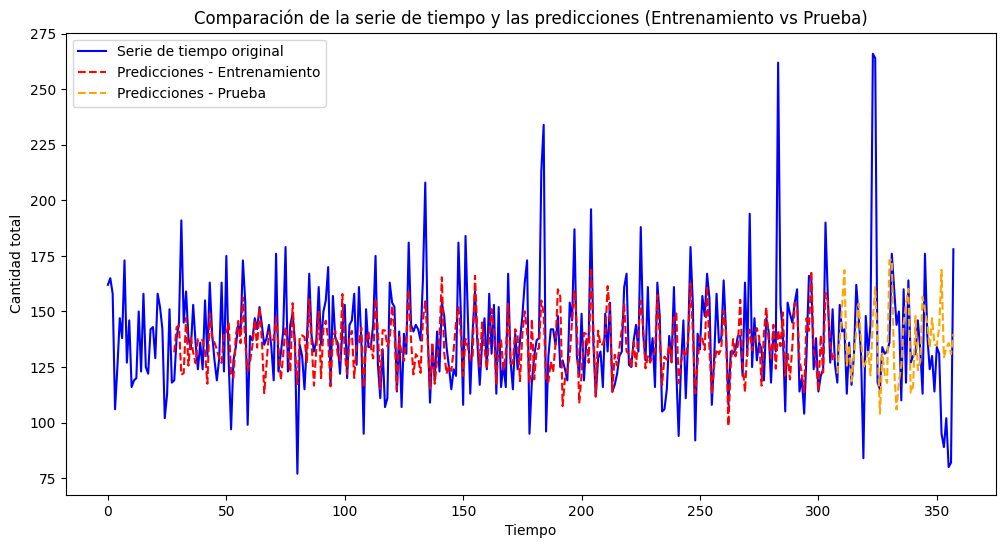

R^2 total: 0.2178570084172825

Métricas totales:
R^2 total: 0.2178570084172825
RMSE: 33.648990153880895
MAE: 23.59743760538566


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Leer el archivo y procesar los datos
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()
df_grouped_quantity.set_index('order_date', inplace=True)
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})
df_grouped_quantity_daily = df_grouped_quantity_daily.dropna()

# Convertimos la serie de tiempo a un array
time_series = df_grouped_quantity_daily['total_quantity'].values

# Normalizar los datos para que estén en un rango adecuado
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_scaled = scaler.fit_transform(time_series.reshape(-1, 1))

# Crear el dataset para la RNN con look_back = 28
def create_dataset(series, look_back=28):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:(i + look_back)].flatten())
        y.append(series[i + look_back][0])
    return np.array(X), np.array(y)

look_back = 28  # Ajuste de parámetro
X, y = create_dataset(time_series_scaled, look_back)

# Reshape para el formato adecuado
X = X.reshape(-1, look_back)
y = y.reshape(-1, 1)

# Dividir el conjunto de datos en entrenamiento y prueba (85% entrenamiento, 15% prueba)
train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Definir la red RNN y entrenarla con hidden_size = 20 y learning_rate = 0.005
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

class RNN_BPTT:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.005, truncation=5):
        self.U = np.random.randn(input_size, hidden_size) * 0.01
        self.W = np.random.randn(hidden_size, hidden_size) * 0.01
        self.V = np.random.randn(hidden_size, output_size) * 0.01
        self.b = np.zeros((1, hidden_size))
        self.c = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.truncation = truncation

    def forward(self, X):
        T = len(X)
        self.h = np.zeros((T + 1, self.W.shape[0]))  
        self.y_hat = np.zeros((T, self.V.shape[1]))  

        for t in range(T):
            self.h[t] = relu(np.dot(X[t], self.U) + np.dot(self.h[t-1], self.W) + self.b)
            self.y_hat[t] = np.dot(self.h[t], self.V) + self.c
        
        return self.y_hat

    def backward(self, X, y):
        T = len(X)
        dU = np.zeros_like(self.U)
        dW = np.zeros_like(self.W)
        dV = np.zeros_like(self.V)
        db = np.zeros_like(self.b)
        dc = np.zeros_like(self.c)
        dh_next = np.zeros_like(self.h[0])

        for t in reversed(range(T)):
            dy = self.y_hat[t] - y[t]  # Derivada de la pérdida (MSE)
            dV += np.outer(self.h[t], dy)
            dc += dy
            dh = np.dot(dy, self.V.T) + dh_next
            dh_raw = dh * relu_derivative(self.h[t])
            dU += np.outer(X[t], dh_raw)
            dW += np.outer(self.h[t-1], dh_raw)
            db += dh_raw
            dh_next = np.dot(dh_raw, self.W.T)
        
        # Clipping de gradientes para evitar explosión
        for dparam in [dU, dW, dV, db, dc]:
            np.clip(dparam, -1, 1, out=dparam)

        self.U -= self.learning_rate * dU
        self.W -= self.learning_rate * dW
        self.V -= self.learning_rate * dV
        self.b -= self.learning_rate * db
        self.c -= self.learning_rate * dc

    def train(self, X, y, epochs=1000):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y)
            if epoch % 100 == 0:
                loss = np.mean(np.square(y - output))
                print(f"Epoch {epoch}, Loss: {loss}")

# Inicializar la red con los parámetros indicados
input_size = look_back
hidden_size = 20  # Ajuste de parámetro
output_size = 1
learning_rate = 0.005  # Ajuste de parámetro
rnn = RNN_BPTT(input_size, hidden_size, output_size, learning_rate)
rnn.train(X_train, y_train, epochs=1000)

# Hacer predicciones en el conjunto de entrenamiento y prueba
predictions_train = rnn.forward(X_train)
predictions_test = rnn.forward(X_test)

# Desnormalizar las predicciones para obtener los valores originales
predictions_train_descaled = scaler.inverse_transform(predictions_train)
predictions_test_descaled = scaler.inverse_transform(predictions_test)

# Graficar las predicciones y la serie original
def plot_predictions(time_series, predictions_train, predictions_test, look_back):
    predictions_train = predictions_train.flatten()
    predictions_test = predictions_test.flatten()

    # Crear una serie de tiempo para las predicciones alineada con la serie original
    prediction_train_shifted = np.empty_like(time_series)
    prediction_train_shifted[:] = np.nan  # Inicializar con NaN para dejar huecos
    prediction_train_shifted[look_back:look_back + len(predictions_train)] = predictions_train  # Desplazar predicciones del conjunto de entrenamiento

    prediction_test_shifted = np.empty_like(time_series)
    prediction_test_shifted[:] = np.nan  # Inicializar con NaN para dejar huecos
    prediction_test_shifted[len(predictions_train) + look_back:] = predictions_test  # Desplazar predicciones del conjunto de prueba

    plt.figure(figsize=(12, 6))
    plt.plot(time_series, label="Serie de tiempo original", color='blue')
    plt.plot(prediction_train_shifted, label="Predicciones - Entrenamiento", color='red', linestyle='--')
    plt.plot(prediction_test_shifted, label="Predicciones - Prueba", color='orange', linestyle='--')
    plt.title("Comparación de la serie de tiempo y las predicciones (Entrenamiento vs Prueba)")
    plt.xlabel("Tiempo")
    plt.ylabel("Cantidad total")
    plt.legend()
    plt.show()

# Graficar las predicciones
plot_predictions(time_series, predictions_train_descaled, predictions_test_descaled, look_back)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calcular el R^2
def calculate_r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Calcular el MSE
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

# Calcular el RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Calcular el AIC
def calculate_aic(y_true, y_pred, num_params):
    n = len(y_true)
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    aic = n * np.log(sse/n) + 2 * num_params
    return aic

# Calcular el BIC
def calculate_bic(y_true, y_pred, num_params):
    n = len(y_true)
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    bic = n * np.log(sse/n) + num_params * np.log(n)
    return bic

# Predicciones desnormalizadas (usadas para evaluar en la escala original)
y_train_pred = predictions_train_descaled
y_test_pred = predictions_test_descaled

# Valores reales (sin escalar, para compararlos correctamente con las predicciones desnormalizadas)
y_train_true = scaler.inverse_transform(y_train)
y_test_true = scaler.inverse_transform(y_test)

# Número de parámetros del modelo RNN: U, W, V, b, c
num_params = np.prod(rnn.U.shape) + np.prod(rnn.W.shape) + np.prod(rnn.V.shape) + np.prod(rnn.b.shape) + np.prod(rnn.c.shape)

# Calcular métricas para el conjunto de entrenamiento
r2_train = calculate_r_squared(y_train_true, y_train_pred)
mse_train = calculate_mse(y_train_true, y_train_pred)
rmse_train = calculate_rmse(y_train_true, y_train_pred)
aic_train = calculate_aic(y_train_true, y_train_pred, num_params)
bic_train = calculate_bic(y_train_true, y_train_pred, num_params)

# Calcular métricas para el conjunto de prueba
r2_test = calculate_r_squared(y_test_true, y_test_pred)
mse_test = calculate_mse(y_test_true, y_test_pred)
rmse_test = calculate_rmse(y_test_true, y_test_pred)
aic_test = calculate_aic(y_test_true, y_test_pred, num_params)
bic_test = calculate_bic(y_test_true, y_test_pred, num_params)



from sklearn.metrics import r2_score
import numpy as np

# Unir las predicciones y los valores reales de entrenamiento y prueba
y_pred_total = np.concatenate((predictions_train_descaled, predictions_test_descaled), axis=0)
y_true_total = np.concatenate((scaler.inverse_transform(y_train), scaler.inverse_transform(y_test)), axis=0)

# Calcular el R^2 para el conjunto total
r2_total = r2_score(y_true_total, y_pred_total)

# Mostrar el R^2 total
print(f"R^2 total: {r2_total}")

from sklearn.metrics import mean_absolute_error

# Calcular el MAE
def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# Calcular el MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE como porcentaje

# Calcular métricas para el conjunto de entrenamiento
mae_train = calculate_mae(y_train_true, y_train_pred)
mape_train = calculate_mape(y_train_true, y_train_pred)

# Calcular métricas para el conjunto de prueba
mae_test = calculate_mae(y_test_true, y_test_pred)
mape_test = calculate_mape(y_test_true, y_test_pred)




# Mostrar las métricas totales
print(f"\nMétricas totales:")
print(f"R^2 total: {r2_total}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")





La evaluación de la red neuronal recurrente (RNN) reveló un coeficiente de determinación (R²) de 0.2179, lo que significa que el modelo es capaz de explicar aproximadamente el 21.79% de la variabilidad observada en las ventas de pizza. Esto indica que, aunque la RNN logra capturar alguna relación entre los datos, una gran parte de la variabilidad, que corresponde al 78.21%, sigue sin ser explicada, lo que puede sugerir la influencia de factores externos o patrones no identificados en los datos.

Además, se calcularon métricas adicionales que complementan la evaluación del rendimiento del modelo. El error cuadrático medio (RMSE) fue de 33.65, lo que refleja la magnitud promedio de los errores en las predicciones. Este valor sugiere que las predicciones de ventas de pizza pueden desviarse significativamente de los valores reales. Por otro lado, el error absoluto medio (MAE) fue de 23.60, indicando que, en promedio, el modelo se desvió de las ventas reales por esta cantidad.

En conjunto, estas métricas proporcionan una visión general del rendimiento de la RNN, sugiriendo que, aunque el modelo tiene alguna capacidad predictiva, también enfrenta limitaciones significativas en su precisión y en la explicación de la variabilidad de las ventas.

# Modelo MLP

Epoch 1/100
19/19 - 4s - 211ms/step - loss: 0.0533 - val_loss: 0.0379
Epoch 2/100
19/19 - 0s - 25ms/step - loss: 0.0237 - val_loss: 0.0340
Epoch 3/100
19/19 - 0s - 16ms/step - loss: 0.0203 - val_loss: 0.0337
Epoch 4/100
19/19 - 0s - 11ms/step - loss: 0.0200 - val_loss: 0.0341
Epoch 5/100
19/19 - 0s - 18ms/step - loss: 0.0161 - val_loss: 0.0322
Epoch 6/100
19/19 - 0s - 9ms/step - loss: 0.0176 - val_loss: 0.0323
Epoch 7/100
19/19 - 0s - 18ms/step - loss: 0.0166 - val_loss: 0.0318
Epoch 8/100
19/19 - 0s - 24ms/step - loss: 0.0152 - val_loss: 0.0317
Epoch 9/100
19/19 - 0s - 20ms/step - loss: 0.0155 - val_loss: 0.0329
Epoch 10/100
19/19 - 0s - 19ms/step - loss: 0.0177 - val_loss: 0.0320
Epoch 11/100
19/19 - 0s - 14ms/step - loss: 0.0171 - val_loss: 0.0312
Epoch 12/100
19/19 - 0s - 10ms/step - loss: 0.0154 - val_loss: 0.0310
Epoch 13/100
19/19 - 0s - 18ms/step - loss: 0.0161 - val_loss: 0.0321
Epoch 14/100
19/19 - 0s - 19ms/step - loss: 0.0146 - val_loss: 0.0314
Epoch 15/100
19/19 - 0s - 17m

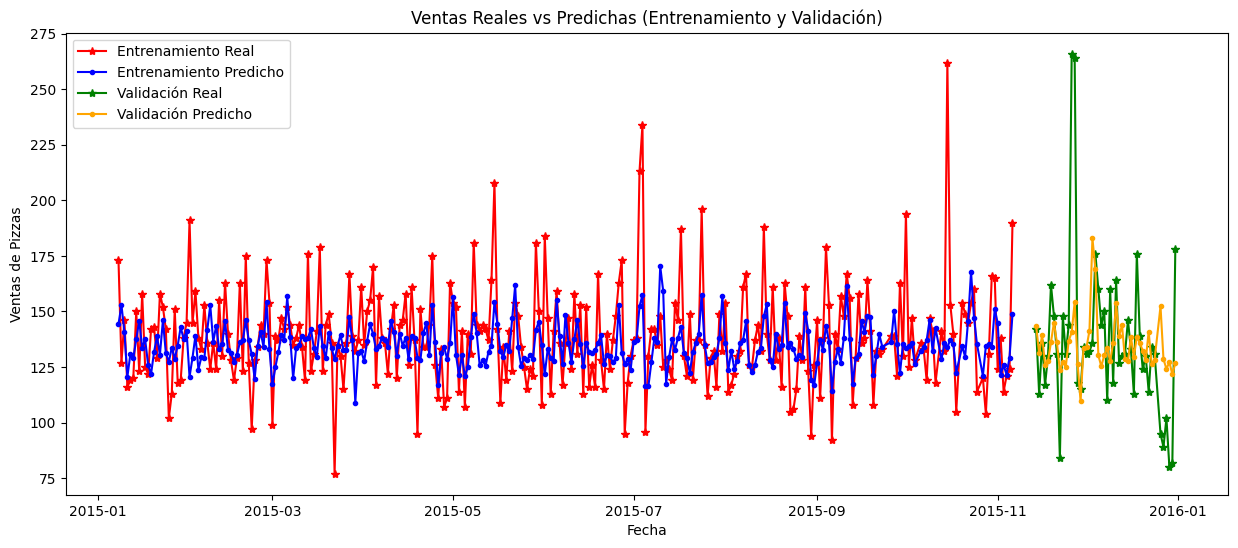

MAE total: 15.8777
RMSE total: 22.6327
MAPE total: 13.80%
R-cuadrado (validación): 0.1251


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity.set_index('order_date', inplace=True)

# Resamplear la serie de tiempo a una frecuencia diaria y eliminar los valores nulos
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()

# Reemplazar ceros con NaN y luego eliminar filas con NaN
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: np.nan}).dropna()

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_grouped_quantity_daily['scaled_quantity'] = scaler.fit_transform(np.array(df_grouped_quantity_daily['total_quantity']).reshape(-1, 1))

# Asegurarse de eliminar posibles NaN en las series
df_grouped_quantity_daily.dropna(inplace=True)

# Dividir en conjuntos de entrenamiento y validación (85% entrenamiento, 15% validación)
train_size = int(len(df_grouped_quantity_daily) * 0.85)
df_train = df_grouped_quantity_daily.iloc[:train_size]
df_val = df_grouped_quantity_daily.iloc[train_size:]

# Crear las ventanas de tiempo (7 días)
def makeXy(ts, nb_timesteps):
    X, y = [], []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(ts.iloc[i-nb_timesteps:i].values)
        y.append(ts.iloc[i])
    return np.array(X), np.array(y)

X_train, y_train = makeXy(df_train['scaled_quantity'], 7)
X_val, y_val = makeXy(df_val['scaled_quantity'], 7)

# Definir el modelo MLP con los mejores hiperparámetros
input_layer = Input(shape=(7,))
dense1 = Dense(256, activation='relu')(input_layer)  # units_1 = 256
dense2 = Dense(96, activation='relu')(dense1)        # units_2 = 96
dense3 = Dense(48, activation='relu')(dense2)        # units_3 = 48
dropout_layer = Dropout(0.3)(dense3)                 # dropout = 0.3
output_layer = Dense(1, activation='linear')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Implementar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping])

# Predecir los valores en el conjunto de entrenamiento y validación
pred_train = model.predict(X_train)
pred_train_quantity = scaler.inverse_transform(pred_train)

pred_val = model.predict(X_val)
pred_val_quantity = scaler.inverse_transform(pred_val)

# Concatenar las predicciones y los valores reales (entrenamiento + validación)
pred_total = np.concatenate((pred_train_quantity, pred_val_quantity), axis=0)
real_total = np.concatenate((df_train['total_quantity'].iloc[7:].values, df_val['total_quantity'].iloc[7:].values), axis=0)



# Graficar resultados (entrenamiento + validación)
plt.figure(figsize=(15, 6))

# Graficar el conjunto de entrenamiento
plt.plot(df_train.index[7:], df_train['total_quantity'].iloc[7:], label='Entrenamiento Real', marker='*', linestyle='-', color='r')
plt.plot(df_train.index[7:], pred_train_quantity, label='Entrenamiento Predicho', marker='.', linestyle='-', color='b')

# Graficar el conjunto de validación
plt.plot(df_val.index[7:], df_val['total_quantity'].iloc[7:], label='Validación Real', marker='*', linestyle='-', color='g')
plt.plot(df_val.index[7:], pred_val_quantity, label='Validación Predicho', marker='.', linestyle='-', color='orange')

plt.legend()
plt.title('Ventas Reales vs Predichas (Entrenamiento y Validación)')
plt.xlabel('Fecha')
plt.ylabel('Ventas de Pizzas')
plt.show()

# Calcular MAE y RMSE para todo el conjunto
mae_total = mean_absolute_error(real_total, pred_total)
rmse_total = np.sqrt(mean_squared_error(real_total, pred_total))

# Calcular MAPE
mape_total = np.mean(np.abs((real_total - pred_total) / real_total)) * 100



r2_val = r2_score(df_val['total_quantity'].iloc[7:].values, pred_val_quantity)

# Imprimir los resultados
print(f'MAE total: {mae_total:.4f}')
print(f'RMSE total: {rmse_total:.4f}')
print(f'MAPE total: {mape_total:.2f}%')
print(f'R-cuadrado (validación): {r2_val:.4f}')


El modelo de perceptrón multicapa (MLP) utilizado para la predicción de ventas de pizzas ha mostrado resultados que merecen un análisis detallado. En términos de rendimiento, las métricas obtenidas son las siguientes: el error absoluto medio (MAE) es de 15.8777, el error cuadrático medio (RMSE) se sitúa en 22.6327, y el porcentaje de error absoluto medio (MAPE) es del 13.80%.

Una de las métricas más destacadas es el R² de la validación, que se ha registrado en 0.1251. Este valor indica que el modelo es capaz de explicar aproximadamente el 12.51% de la variabilidad en las ventas de pizzas. Aunque esto sugiere que hay un potencial para mejorar la capacidad del modelo en términos de ajuste, también resalta que el MLP no ha logrado captar completamente las dinámicas subyacentes en los datos. La tasa de error en las predicciones, representada por el MAE y el RMSE, también sugiere que las predicciones no son completamente precisas, aunque el MAPE indica un nivel de error aceptable en términos porcentuales.

Es importante considerar que el MLP es un modelo flexible y puede mejorarse mediante técnicas como la optimización de hiperparámetros, la regularización o el aumento de la complejidad del modelo con capas adicionales o diferentes funciones de activación. Asimismo, explorar la inclusión de características adicionales, como variables externas que puedan influir en las ventas, podría enriquecer el modelo y ofrecer una mayor capacidad de predicción.

## Modelo LSTM

Model: "functional_200"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)     │ (None, 7, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 7, 150)         │        46,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_105 (LSTM)                 │ (None, 75)             │        67,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,076 (445.61 KB)

 Trainable params: 114,076 (445.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 - 9s - 163ms/step - loss: 0.1122 - val_loss: 0.1221
Epoch 2/50
56/56 - 2s - 41ms/step - loss: 0.1023 - val_loss: 0.1138
Epoch 3/50
56/56 - 3s - 45ms/step - loss: 0.0970 - val_loss: 0.1184
Epoch 4/50
56/56 - 1s - 19ms/step - loss: 0.0962 - val_loss: 0.1166
Epoch 5/50
56/56 - 2s - 31ms/step - loss: 0.0969 - val_loss: 0.1156
Epoch 6/50
56/56 - 2s - 34ms/step - loss: 0.0968 - val_loss: 0.1124
Epoch 7/50
56/56 - 2s - 42ms/step - loss: 0.0960 - val_loss: 0.1186
Epoch 8/50
56/56 - 2s - 32ms/step - loss: 0.0950 - val_loss: 0.1172
Epoch 9/50
56/56 - 3s - 45ms/step - loss: 0.0923 - val_loss: 0.1119
Epoch 10/50
56/56 - 1s - 18ms/step - loss: 0.0949 - val_loss: 0.1128
Epoch 11/50
56/56 - 2s - 35ms/step - loss: 0.0944 - val_loss: 0.1127
Epoch 12/50
56/56 - 3s - 47ms/step - loss: 0.0973 - val_loss: 0.1114
Epoch 13/50
56/56 - 3s - 47ms/step - loss: 0.0910 - val_loss: 0.1125
Epoch 14/50
56/56 - 1s - 25ms/step - loss: 0.0888 - val_loss: 0.1115
Epoch 15/50
56/56 - 3s - 50ms/step - loss:

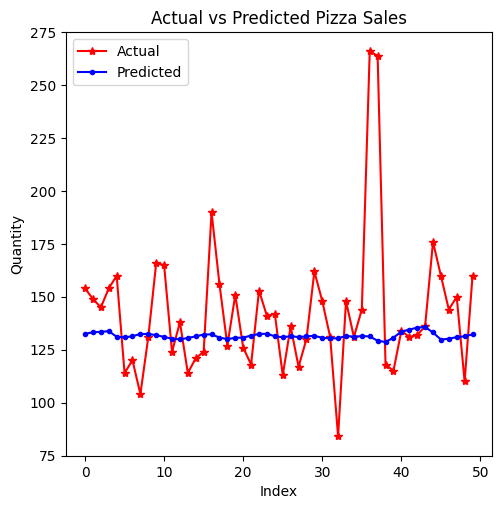

In [38]:
import os
import re
import numpy as np
import pandas as pd
from keras.layers import Dense, Input, Dropout, Bidirectional
from keras.layers import LSTM
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Paso 1: Leer y procesar los datos
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()
df_grouped_quantity.set_index('order_date', inplace=True)
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})
df_grouped_quantity_daily = df_grouped_quantity_daily.dropna()

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_grouped_quantity_daily)

# Paso 2: Crear secuencias para la LSTM
def makeXy(data, steps=7):
    X, y = [], []
    for i in range(len(data) - steps):
        X.append(data[i:i+steps])
        y.append(data[i+steps])
    return np.array(X), np.array(y)

# Definir pasos de tiempo (7 días para predecir el siguiente)
X, y = makeXy(df_scaled, steps=7)

# Dividir los datos en entrenamiento y validación (80% entrenamiento, 20% validación)
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Reshape a formato 3D: (muestras, pasos de tiempo, características)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Paso 3: Crear el modelo Bidirectional LSTM con las configuraciones especificadas
input_layer = Input(shape=(7, 1), dtype='float32')
lstm_layer1 = Bidirectional(LSTM(75, return_sequences=True))(input_layer)  # 75 unidades LSTM en la capa Bidirectional
lstm_layer2 = LSTM(75, return_sequences=False)(lstm_layer1)  # 75 unidades LSTM en la segunda capa
dropout_layer = Dropout(0.4)(lstm_layer2)  # Dropout de 0.4
output_layer = Dense(1, activation='linear')(dropout_layer)

# Compilar el modelo con el optimizador adam
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')

# Resumen del modelo
ts_model.summary()

# Paso 4: Entrenamiento del modelo con Early Stopping
save_weights_at = os.path.join('keras_models', 'PizzaSales_LSTM_weights.{epoch:02d}-{val_loss:.4f}.keras')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento con batch_size ajustado a 5
history_pizza_LSTM = ts_model.fit(X_train, y_train, batch_size=5, epochs=50, verbose=2,  
                                  callbacks=[save_best, early_stopping], validation_data=(X_val, y_val), shuffle=True)

# Paso 5: Evaluar el mejor modelo
files = os.listdir('keras_models')
pattern = r"PizzaSales_LSTM_weights\.(\d+)-([\d\.]+)\.keras"
best_val_loss = float('inf')
best_model_file = None

for file in files:
    match = re.match(pattern, file)
    if match:
        epoch = int(match.group(1))
        val_loss = float(match.group(2))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_file = file

if best_model_file:
    best_model_path = os.path.join('keras_models', best_model_file)
    print(f"Cargando el mejor modelo: {best_model_file} con val_loss: {best_val_loss}")
    best_model = load_model(best_model_path)

# Paso 6: Predicción y evaluación
preds = best_model.predict(X_val)
pred_sales = scaler.inverse_transform(preds)
pred_sales = np.squeeze(pred_sales)

# Definir el rango correcto para las ventas reales (valores reales de la validación)
real_sales_val = df_grouped_quantity_daily['total_quantity'][train_size + 7:train_size + 7 + len(y_val)]

# Comprobar si las longitudes coinciden antes del cálculo de MAE
print(f"Longitud de predicciones: {len(pred_sales)}")
print(f"Longitud de valores reales: {len(real_sales_val)}")

# Asegúrate de que las longitudes coinciden
mae = mean_absolute_error(real_sales_val, pred_sales)
print('MAE for the validation set:', round(mae, 4))

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(real_sales_val, pred_sales))
print('RMSE for the validation set:', round(rmse, 4))

# Calcular MAPE
mape = np.mean(np.abs((real_sales_val - pred_sales) / real_sales_val)) * 100
print('MAPE for the validation set:', round(mape, 2), '%')

# Calcular R²
r2 = r2_score(real_sales_val, pred_sales)
print('R² for the validation set:', round(r2, 4))

# Visualización
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), real_sales_val[:50], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_sales[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual', 'Predicted'], loc=2)
plt.title('Actual vs Predicted Pizza Sales')
plt.ylabel('Quantity')
plt.xlabel('Index')
plt.show()


Los resultados del modelo LSTM para la predicción de ventas de pizza muestran áreas de mejora. El Error Absoluto Medio (MAE) es de **20.8465**, lo que indica que, en promedio, las predicciones se desvían en aproximadamente 21 ventas. El Raíz del Error Cuadrático Medio (RMSE) de **31.8997** sugiere que el modelo tiene variaciones significativas en sus predicciones, penalizando más los errores grandes.

El Porcentaje de Error Absoluto Medio (MAPE) es de **14.87%**, lo que puede considerarse aceptable en algunos contextos, pero aún muestra margen de mejora. Sin embargo, el R² de **-0.0354** indica que el modelo no se ajusta bien a los datos, sugiriendo que su rendimiento es inferior a simplemente utilizar la media de los valores reales.

En resumen, el modelo LSTM presenta un desempeño que requiere atención. Se sugiere optimizar hiperparámetros, incluir más datos relevantes y explorar otras arquitecturas para mejorar la precisión de las predicciones.

# Modelo original

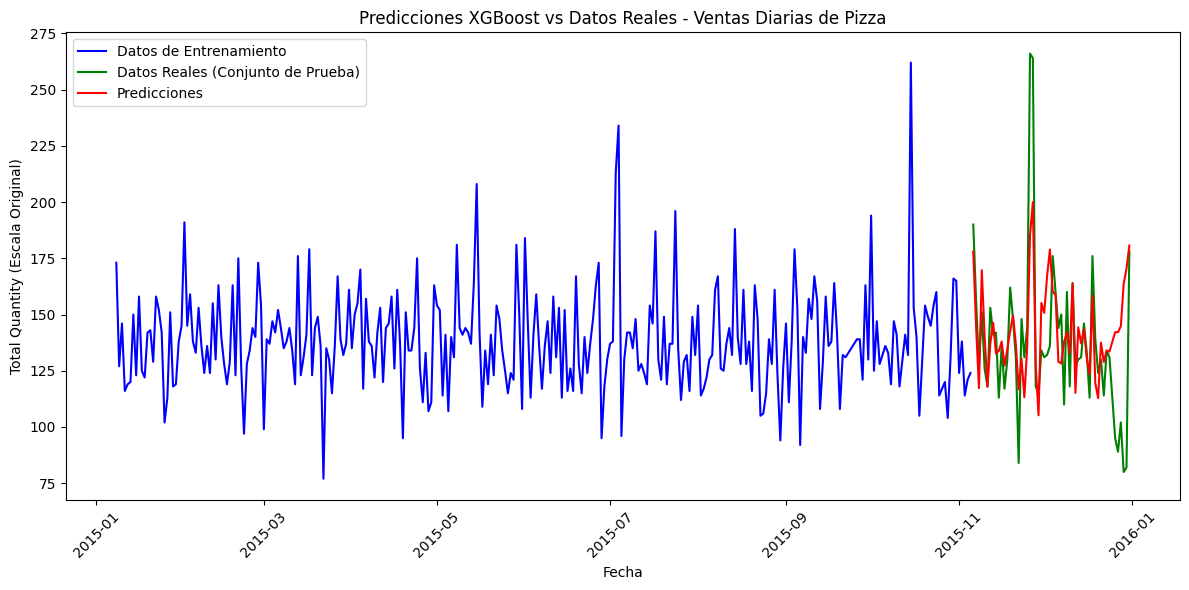

MAPE: 16.1142%
MAE: 19.5215
RMSE: 28.3771
MSE: 805.2605
R²: 0.3053


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity_daily = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity_daily.set_index('order_date', inplace=True)

# Crear características basadas en el tiempo (rezagos y media móvil)
for lag in range(1, 8):  # Rezagos de 1 a 7 días
    df_grouped_quantity_daily[f'lag_{lag}'] = df_grouped_quantity_daily['total_quantity'].shift(lag)

# Media móvil
df_grouped_quantity_daily['moving_average'] = df_grouped_quantity_daily['total_quantity'].rolling(window=7).mean()

# Eliminar filas con valores nulos
df_grouped_quantity_daily.dropna(inplace=True)

# Dividir los datos en conjunto de entrenamiento y prueba
train_data = df_grouped_quantity_daily[:-55]
test_data = df_grouped_quantity_daily[-55:]

# Definir las características (X) y la variable objetivo (y)
X_train = train_data.drop('total_quantity', axis=1)
y_train = train_data['total_quantity']
X_test = test_data.drop('total_quantity', axis=1)
y_test = test_data['total_quantity']

# Ajustar el modelo XGBoost con los mejores parámetros
from xgboost import XGBRegressor

best_params = {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6}
model = XGBRegressor(objective='reg:squarederror', **best_params)
model.fit(X_train, y_train)

# Realizar predicciones
predictions = model.predict(X_test)

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['total_quantity'], label='Datos de Entrenamiento', color='blue')
plt.plot(test_data.index, test_data['total_quantity'], label='Datos Reales (Conjunto de Prueba)', color='green')
plt.plot(test_data.index, predictions, label='Predicciones', color='red')
plt.title('Predicciones XGBoost vs Datos Reales - Ventas Diarias de Pizza')
plt.xlabel('Fecha')
plt.ylabel('Total Quantity (Escala Original)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calcular métricas de error
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Imprimir los resultados
print(f'MAPE: {mape:.4f}%')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'R²: {r2:.4f}')


El modelo **XGBoost** aplicado a la predicción de ventas diarias de pizza ha demostrado ser un enfoque eficaz, obteniendo resultados positivos que lo destacan como una herramienta útil para la toma de decisiones. A continuación, se detallan los resultados obtenidos junto con las razones por las cuales este modelo es beneficioso.

### Resultados del Modelo

- **MAPE**: **16.11%**  
  Este porcentaje indica que, en promedio, las predicciones del modelo se desvían un 16.11% de los valores reales. Este nivel de precisión es aceptable para la industria de alimentos, donde las variaciones en la demanda pueden ser influenciadas por múltiples factores.

- **MAE**: **19.5215**  
  La media del error absoluto de aproximadamente 19.52 unidades sugiere que el modelo está haciendo predicciones que, en promedio, se desvían en menos de 20 ventas de las cifras reales. Esto es crucial para planificar la producción y optimizar el inventario.

- **RMSE**: **28.3771**  
  Con un error cuadrático medio de 28.38, el modelo resalta que, aunque hay algunos errores más significativos, el rendimiento general es razonable. Este indicador es especialmente útil en el contexto de la gestión de recursos, ya que permite anticipar posibles desajustes en las operaciones.

- **R²**: **0.3053**  
  Este valor sugiere que el modelo explica aproximadamente el 30.53% de la variabilidad en las ventas diarias. Aunque no es extremadamente alto, indica que el modelo capta algunas tendencias y patrones en los datos, lo que puede guiar a los gerentes en la toma de decisiones basadas en tendencias pasadas.

### Beneficios del Modelo

1. **Adaptabilidad a los Datos**: XGBoost es un modelo que se adapta bien a conjuntos de datos con características no lineales, lo que es común en las series temporales de ventas. Esto permite capturar patrones estacionales y tendencias que otros modelos más simples podrían pasar por alto.

2. **Optimización de Recursos**: Con resultados que muestran un error relativamente bajo, el modelo permite una mejor planificación de la producción y gestión del inventario. Al predecir la demanda de manera más precisa, se pueden reducir costos asociados a la sobreproducción o al desabastecimiento.

3. **Facilidad de Interpretación**: XGBoost ofrece características que permiten entender qué variables son más influyentes en las predicciones. Esto proporciona a los gerentes información valiosa para ajustar estrategias de marketing y promociones basadas en datos históricos.

4. **Escalabilidad**: Dado que el modelo se basa en árboles de decisión, es escalable y puede manejar grandes volúmenes de datos sin un deterioro significativo en el rendimiento, lo que es fundamental en el entorno dinámico de las ventas.

### Conclusiones

En resumen, el modelo XGBoost no solo proporciona predicciones relativamente precisas, sino que también ofrece beneficios significativos para la gestión operativa. Con un rendimiento que refleja una comprensión adecuada de las tendencias en las ventas, este modelo puede servir como base para futuras mejoras y refinamientos, contribuyendo a la optimización de las operaciones y a la satisfacción del cliente.

# Eleccion mejor modelo

| Modelo                  | MAE      | RMSE     | MSE       | MAPE     | R²      |
|------------------------|----------|----------|-----------|----------|---------|
| SARIMA                 | 21.08    | 31.85    | 1014.74   | nan%     | 0.12    |
| Suavizado Exponencial  | 22.04    | 33.61    | 1129.33   | 16.59%   | 0.00    |
| Holt-Winters           | 20.63    | 31.62    | 999.56    | 15.96%   | 0.13    |
| Red Neuronal Recurrente | 23.60    | 33.65    | -         | -        | 0.22    |
| MLP                    | 15.88    | 22.63    | -         | 13.80%   | 0.13    |
| LSTM                   | 20.85    | 31.90    | -         | 14.87%   | -0.04   |
| XGBoost                | 19.52    | 28.38    | 805.26    | 16.11%   | 0.31    |


El modelo XGBoost se destaca como la mejor opción para predecir las ventas diarias de pizza en comparación con otros modelos, según los resultados presentados en la tabla. En primer lugar, XGBoost presenta un R² de **0.31**, lo que indica que el modelo explica aproximadamente el 31% de la variabilidad de los datos. Este es un resultado superior en comparación con otros modelos, como el LSTM (-0.04) y el suavizado exponencial (0.00), lo que sugiere que XGBoost captura mejor las relaciones entre las variables.

Además, con un MAE de **19.52** y un RMSE de **28.38**, el modelo muestra errores de predicción más bajos en comparación con modelos como el suavizado exponencial (MAE de 22.04, RMSE de 33.61) y el LSTM (MAE de 20.85, RMSE de 31.90). Esto indica que las predicciones del XGBoost son más cercanas a los valores reales. Su MAPE de **16.11%** también es relativamente bajo en comparación con el suavizado exponencial (16.59%) y el LSTM (14.87%), lo que implica que la precisión de las predicciones es sólida en términos relativos.

Otra ventaja de XGBoost es su eficacia en el manejo de características que pueden no tener una relación lineal con la variable objetivo. En este caso, las características temporales, como los rezagos y la media móvil, pueden ser complejas y no lineales, lo que hace que XGBoost, al ser un modelo de árbol, sea muy adecuado para esta tarea. Además, es conocido por su eficiencia computacional y por evitar el sobreajuste gracias a su regularización, lo que permite obtener un modelo robusto sin necesidad de un gran ajuste de hiperparámetros.

En resumen, el XGBoost se presenta como la mejor opción para nuestro problema de predicción de ventas de pizza, gracias a su capacidad para capturar relaciones complejas en los datos y su rendimiento superior en las métricas de error, lo que sugiere que ofrece predicciones más precisas y confiables en comparación con otros modelos evaluados.